# SignABC - BISINDO Sign Language Learning App for Children

<div class="alert alert-block alert-success">
📌 This notebook is created for a capstone project, we are creating a learning app for children to help them learn about BISINDO sign language.
</div>

# Import Dependencies

In [ ]:
import os
import random
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import PIL
import PIL.Image
import tensorflow_hub as hub

from google.colab import drive, files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Setup

In [ ]:
# Mount google drive
drive.mount('/content/drive/')

# Unzip dataset file
!unzip "/content/drive/MyDrive/Capstone Project ML/Zipped dataset/Dataset_Experimen_Khresna/Dataset_KhresnaV4(NoSplit, NoPersonInBackground, NoAug).zip" -d "/content"


In [ ]:
# Dataset path
data_dir = pathlib.Path('/content/Dataset_KhresnaV4(NoSplit, NoPersonInBackground, NoAug)')

# Image count
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.PNG')))
print(image_count)

12525


# Dataset

In [ ]:
# Dataset properties
batch_size = 100
img_height = 224
img_width = 224

In [ ]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12525 files belonging to 26 classes.
Using 10020 files for training.


In [ ]:
# Testing dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12525 files belonging to 26 classes.
Using 2505 files for validation.


In [ ]:
# Labels list
class_names = np.array(train_ds.class_names)
print(class_names)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


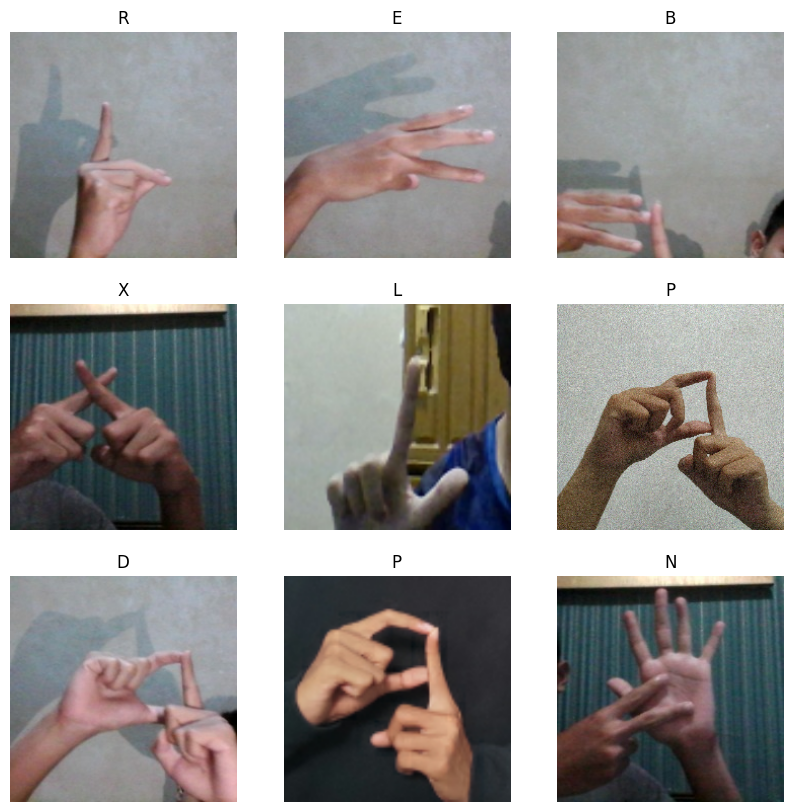

In [ ]:
# Dataset sample

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomContrast(factor=0.8),
])

In [ ]:
# Normalizization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(dataset, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  dataset = dataset.map(lambda x, y: (normalization_layer(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    dataset = dataset.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Apply preprocessing to the dataset
train_ds = preprocess(train_ds, shuffle=True, augment=True)
val_ds = preprocess(val_ds)

# Without Transfer Learning



## Model Architecture

In [ ]:
# # Method to create model
# def create_uncompiled_model():

#     num_classes = len(class_names)

#     model = tf.keras.Sequential([
#       tf.keras.layers.Conv2D(32, 5, input_shape=(img_height, img_width, 3), activation='relu'),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Conv2D(64, 3, activation='relu'),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Conv2D(64, 3, activation='relu'),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(128, activation='relu'),
#       tf.keras.layers.Dense(num_classes, activation = 'softmax')
#     ])

#     return model

## Tune Learning Rate

In [ ]:
# # Method to find the 'best' learning rate
# def adjust_learning_rate(dataset):

#     model = create_uncompiled_model()

#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

#     optimizer = tf.keras.optimizers.Adam()

#     model.compile(optimizer=optimizer,
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy'])

#     history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

#     return history

In [ ]:
# Find the 'best' learning rate
# lr_history = adjust_learning_rate(train_ds)

In [ ]:
# Plot the result
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.axis([1e-4, 10, 0, 10])

> The 'best' learning rate would be around 1e-3 as that area has quite stable loss compared to the other area.

## Train Model

In [ ]:
# model = create_uncompiled_model()

# model.compile(
#   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#   metrics=['accuracy'])

# history = model.fit(train_ds, validation_data=val_ds, epochs=20)

## Model Evaluation

In [ ]:
# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc=history.history['accuracy']
# val_acc=history.history['val_accuracy']
# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs=range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot(epochs, acc, 'r', "Training Accuracy")
# plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
# plt.title('Training and validation accuracy')
# plt.show()
# print("")

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot(epochs, loss, 'r', "Training Loss")
# plt.plot(epochs, val_loss, 'b', "Validation Loss")
# plt.show()

## Save Model

In [ ]:
# model.save('saved_models/model_noaug_v3_0')

In [ ]:
# !zip -r "/content/model_noaug_v3_0.zip" "/content/saved_models/model_noaug_v3_0"

# With Transfer Learning



## Load Pre-trained Model

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [ ]:
# Create layer from pre-trained model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

## Model Architecture

In [ ]:
# Method to create model
def create_uncompiled_model():

    num_classes = len(class_names)

    model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

## Tune Learning Rate

In [ ]:
# Method to find the 'best' learning rate
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Find the 'best' learning rate
# lr_history = adjust_learning_rate(train_ds)

In [ ]:
# Plot the result
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.axis([1e-4, 10, 0, 10])

> The 'best' learning rate would be around 0.004 as that area has quite
stable loss compared to the other area.

## Train Model

In [ ]:
model_tl = create_uncompiled_model()

model_tl.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model_tl.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
101/101 [==============================] - 200s 615ms/step - loss: 0.9189 - accuracy: 0.7624 - val_loss: 0.2449 - val_accuracy: 0.9477
Epoch 2/50
101/101 [==============================] - 14s 134ms/step - loss: 0.1891 - accuracy: 0.9570 - val_loss: 0.1568 - val_accuracy: 0.9641
Epoch 3/50
101/101 [==============================] - 14s 135ms/step - loss: 0.1046 - accuracy: 0.9817 - val_loss: 0.1246 - val_accuracy: 0.9681
Epoch 4/50
101/101 [==============================] - 14s 136ms/step - loss: 0.0664 - accuracy: 0.9904 - val_loss: 0.1033 - val_accuracy: 0.9721
Epoch 5/50
101/101 [==============================] - 14s 137ms/step - loss: 0.0470 - accuracy: 0.9948 - val_loss: 0.0912 - val_accuracy: 0.9764
Epoch 6/50
101/101 [==============================] - 14s 135ms/step - loss: 0.0366 - accuracy: 0.9951 - val_loss: 0.0887 - val_accuracy: 0.9768
Epoch 7/50
101/101 [==============================] - 13s 133ms/step - loss: 0.0300 - accuracy: 0.9959 - val_loss: 0.0846 - val_a

## Model Evaluation

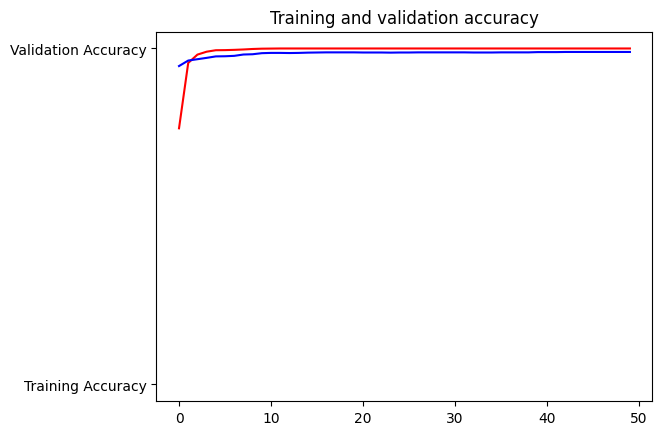

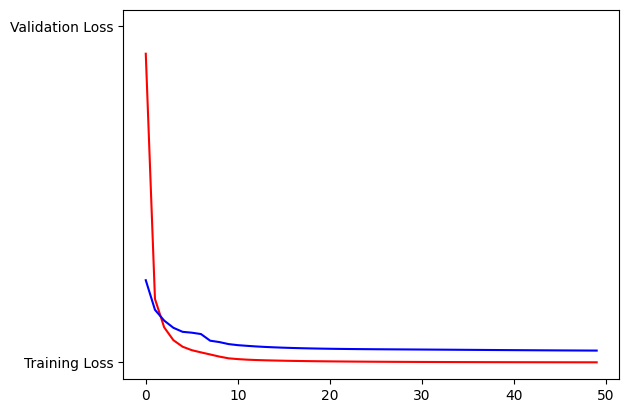

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## Test with Uploaded Image

In [ ]:
# Load test samples for specific class

def create_test_generator(chosen_class):
  path = '/content/drive/MyDrive/Capstone Project ML/Test samples/{}-samples'.format(chosen_class)

  test_datagen = ImageDataGenerator(rescale=1/255.)

  test_generator = test_datagen.flow_from_directory(path,
                                classes=[chosen_class],
                                class_mode=None,
                                shuffle=False,
                                target_size=(224, 224))
  return test_generator

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']

for label in labels:
  print("========================= Making predictions for class {} =========================".format(label))

  test_generator = create_test_generator(label)
  predictions = model_tl.predict_generator(test_generator)

  for prediction in predictions:
    print(class_names[tf.math.argmax(prediction, axis=-1)])

========================= Making predictions for class A =========================
Found 5 images belonging to 1 classes.


<ipython-input-35-274c02f711a6>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_tl.predict_generator(test_generator)


A
A
A
A
A
========================= Making predictions for class B =========================
Found 10 images belonging to 1 classes.
B
B
B
B
B
B
B
B
B
B
========================= Making predictions for class C =========================
Found 10 images belonging to 1 classes.
C
C
C
C
C
C
C
C
C
C
========================= Making predictions for class D =========================
Found 10 images belonging to 1 classes.
D
D
D
D
D
D
D
A
D
D
========================= Making predictions for class E =========================
Found 10 images belonging to 1 classes.
E
E
E
E
E
E
E
E
E
E
========================= Making predictions for class F =========================
Found 10 images belonging to 1 classes.
F
F
F
F
F
F
F
F
F
F


## Save Model

In [ ]:
# model_tl.save('model_tl_noaug_v4_3')

# converter = tf.lite.TFLiteConverter.from_saved_model('model_tl_noaug_v4_3')
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = converter.convert()
# tflite_model_file = 'model_tl_noaug_v4_3.tflite'

# with open(tflite_model_file, "wb") as f:
#     f.write(tflite_model)

In [ ]:
# !zip -r "/content/model_tl_noaug_v4_3.zip" "/content/model_tl_noaug_v4_3"

  adding: content/model_tl_noaug_v4_3/ (stored 0%)
  adding: content/model_tl_noaug_v4_3/variables/ (stored 0%)
  adding: content/model_tl_noaug_v4_3/variables/variables.index (deflated 78%)
  adding: content/model_tl_noaug_v4_3/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_tl_noaug_v4_3/keras_metadata.pb (deflated 80%)
  adding: content/model_tl_noaug_v4_3/saved_model.pb (deflated 91%)
  adding: content/model_tl_noaug_v4_3/fingerprint.pb (stored 0%)
  adding: content/model_tl_noaug_v4_3/assets/ (stored 0%)
